In [1]:
from transformers import LlavaForConditionalGeneration, LlavaProcessor
import torch
from peft import PeftModel



/root/autodl-tmp/conda/envs/llama_train/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_model_name_or_path = "show_model/model001"
peft_model_name_or_path = "/root/autodl-tmp/Code/LLava_work/output_model_freeze_vison_0712/checkpoint-400"
model = LlavaForConditionalGeneration.from_pretrained(raw_model_name_or_path,device_map="cuda:0", torch_dtype=torch.bfloat16)
model = PeftModel.from_pretrained(model, peft_model_name_or_path, adapter_name="peft_v1")
processor = LlavaProcessor.from_pretrained(raw_model_name_or_path)
model.eval()
print('ok')

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ok


In [3]:
from train_llava.data import LlavaDataset

llavadataset = LlavaDataset("/root/autodl-tmp/Models/LLaVA-CC3M-Pretrain-595K")
len(llavadataset), llavadataset[10]

(595375,
 ('<image>\nProvide a brief description of the given image.',
  'organization is synonymous with azaleas .',
  PosixPath('/root/autodl-tmp/Models/LLaVA-CC3M-Pretrain-595K/images_dl/GCC_train_000177248.jpg')))

In [4]:
testdata = llavadataset[1302]
testdata

('<image>\nRelay a brief, clear account of the picture shown.',
 'large kitchen island with an overhang and dining space next to it',
 PosixPath('/root/autodl-tmp/Models/LLaVA-CC3M-Pretrain-595K/images_dl/GCC_train_001899387.jpg'))

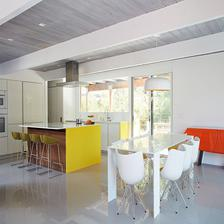

In [5]:
from PIL import Image
Image.open(testdata[2])

In [7]:
def build_model_input(model, processor, testdata:tuple):
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": testdata[0]},
    ]
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # print(prompt)
    # print("*"*20)
    image = Image.open(testdata[2])
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    
    for tk in inputs.keys():
        inputs[tk] = inputs[tk].to(model.device)
    generate_ids = model.generate(**inputs, max_new_tokens=20)
    
    generate_ids = [
        oid[len(iids):] for oid, iids in zip(generate_ids, inputs.input_ids)
    ]

    

    gen_text = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    return gen_text



gen_text = build_model_input(model, processor, testdata)
print(gen_text)
print(len(gen_text))

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


a kitchen with a glass backsplash and a white island .
54


In [8]:
model = model.merge_and_unload()

In [9]:
model.save_pretrained("output_model_lora_merge_001")
processor.save_pretrained("output_model_lora_merge_001")

[2024-07-12 17:14:22,498] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


/root/autodl-tmp/conda/envs/llama_train/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


[]